In [3]:
install.packages("cowplot")
install.packages("themis")
install.packages("kknn") 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(themis)
library(kknn)
options(repr.matrix.max.rows = 9)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [3]:
download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", "wine.zip")

In [4]:
unzip("wine.zip", "winequality-white.csv")

In [8]:
white_wine_data <- read_csv2("winequality-white.csv", show_col_types = FALSE) |>
    mutate_if(is.character, as.numeric) |>
    mutate(quality = as.factor(quality)) |>
    select(quality, `volatile acidity`, `chlorides`, `density`, `pH`, `sulphates` )
    
white_wine_data 

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.



quality,volatile acidity,chlorides,density,pH,sulphates
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,0.27,0.045,1.0010,3,0.45
6,0.30,0.049,0.9940,33,0.49
6,0.28,0.050,0.9951,326,0.44
6,0.23,0.058,0.9956,319,0.40
6,0.23,0.058,0.9956,319,0.40
⋮,⋮,⋮,⋮,⋮,⋮
5,0.32,0.047,0.99490,315,0.46
6,0.24,0.041,0.99254,299,0.46
7,0.29,0.022,0.98869,334,0.38


In [9]:
wine_recipe_balance <- recipe(quality ~ ., data = white_wine_data)|>
    step_upsample(quality, over_ratio = 1, skip = FALSE) |>
    prep()
wine_recipe_balance 

#Creates a recipe to balance the data

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Training data contained 4898 data points and no missing data.

Operations:

Up-sampling based on quality [trained]

In [11]:
balanced_wine <- bake(wine_recipe_balance, white_wine_data)
balanced_wine |> group_by(quality) |> summarise(n = n())

#Creates the balanced dataset

quality,n
<fct>,<int>
3,2198
4,2198
5,2198
6,2198
7,2198
8,2198
9,2198


In [36]:
set.seed(2024)
wine_data_split <- white_wine_data |>           #split of the unbalanced dataset
    initial_split(prop = 0.75, strata = quality)  
wine_data_split_2 <- balanced_wine |>           #split the balanced dataset
    initial_split(prop = 0.75, strata = quality)

wine_data_train <- training(wine_data_split)    #training dataset unbalanced
wine_data_train_2 <- training(wine_data_split_2)#training dataset balancedd
wine_data_test <- testing(wine_data_split)      #testing dataset unbalanced
wine_data_test_2 <- testing(wine_data_split_2)  #testing dataset balanced
wine_vfold <- vfold_cv(wine_data_train_2, v = 5, strata = quality) #5 fold split off the balanced training dataset


In [25]:
#tuning specs of the data

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 


In [26]:
#scaling and centering the data on the recipe

wine_recipe <- recipe(quality ~ ., data = wine_data_train_2 )|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [35]:
#tunes the data with k from 1 to 20
k_vals <- tibble(neighbors = seq(from = 1, to = 20))
wine_tune <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = k_vals) |>
    collect_metrics()
wine_tune
    

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9036882,5,0.002507085,Preprocessor1_Model01
1,roc_auc,hand_till,0.9438181,5,0.001462466,Preprocessor1_Model01
2,accuracy,multiclass,0.9036882,5,0.002507085,Preprocessor1_Model02
2,roc_auc,hand_till,0.9493257,5,0.001635953,Preprocessor1_Model02
3,accuracy,multiclass,0.8492562,5,0.001470637,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,accuracy,multiclass,0.6849087,5,0.0043277895,Preprocessor1_Model19
19,roc_auc,hand_till,0.9282730,5,0.0006831802,Preprocessor1_Model19
20,accuracy,multiclass,0.6795342,5,0.0043431830,Preprocessor1_Model20


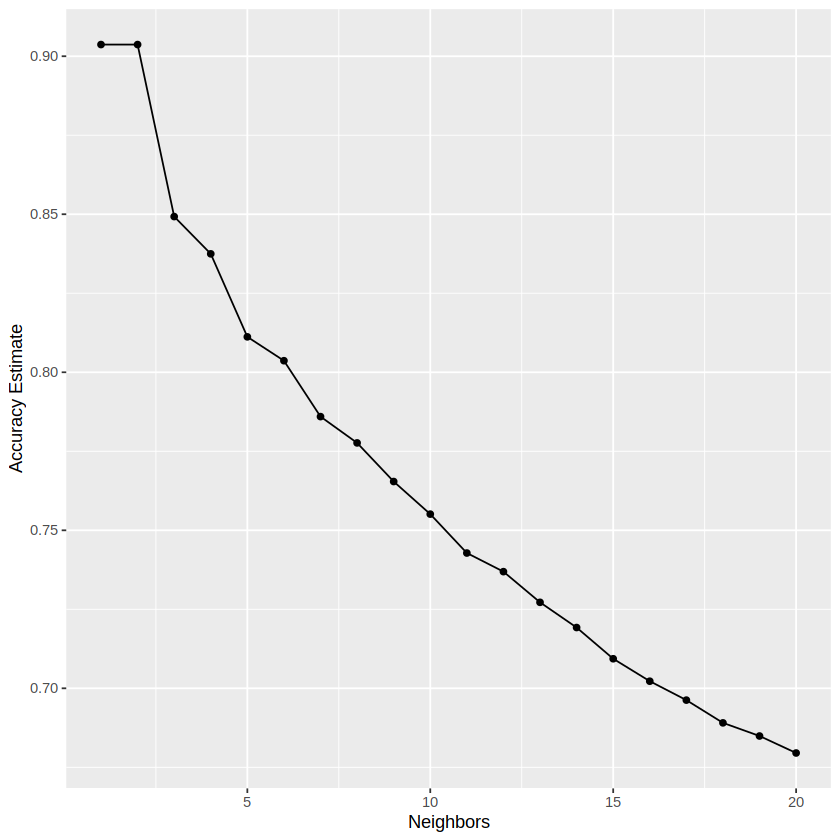

In [38]:
#uses the results of tuning to make a plot

accuracy_versus_k <- wine_tune |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 

accuracy_versus_k

In [29]:
#spec with 1 neighbor since it is the same with either 1 or 2

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
    set_engine("kknn") |>
    set_mode("classification")

In [30]:
#fitting the data

wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_spec) |>
    fit(wine_data_train_2)

In [31]:
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(1,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.08018377
Best kernel: rectangular
Best k: 1

In [39]:
#runs the test data and measures it's accuracy and confusion matrix

wine_predictions <- wine_fit |>
predict(wine_data_test) |>
bind_cols(wine_data_test)

mnist_metrics <- wine_predictions |> 
    metrics(truth = quality, estimate = .pred_class) |>
    filter(.metric == "accuracy")
mnist_metrics

wine_predictions |> 
    conf_mat(truth = quality, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9044898


          Truth
Prediction   3   4   5   6   7   8   9
         3   5   0   1   1   0   0   0
         4   0  39   8   4   2   0   0
         5   0   0 306  21   2   0   0
         6   0   0  32 503   9   0   0
         7   0   0   8  19 209   0   0
         8   0   0   2   6   2  43   0
         9   0   0   0   0   0   0   3